In [26]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Stack Overflow Analysis with Spark


Stack Overflow is a collaboratively edited question-and-answer site originally focused on programming topics. Because of the variety of features tracked, including a variety of feedback metrics, it allows for some open-ended analysis of user behavior on the site.

Stack Exchange (the parent organization) provides an anonymized [data dump](https://archive.org/details/stackexchange), and I'll use Spark to perform data manipulation, analysis, and machine learning on this data set. As a side note, there's also an online data explorer which allows you to query the data interactively.

## Accessing the data


The data is available on the google cloud platform (GCP) bucket (gs://camalot/datacourse/spark.new/miniprojects/spark-stack-data). There are three sub-folders, `allUsers`, `allPosts`, and `allVotes`, which contain Gzipped XML with the following format:

```
<row Body="&lt;p&gt;I always validate my web pages, and I recommend you do the same BUT many large company websites DO NOT and cannot validate because the importance of the website looking exactly the same on all systems requires rules to be broken. &lt;/p&gt;&#10;&#10;&lt;p&gt;In general, valid websites help your page look good even on odd configurations (like cell phones) so you should always at least try to make it validate.&lt;/p&gt;&#10;" CommentCount="0" CreationDate="2008-10-12T20:26:29.397" Id="195995" LastActivityDate="2008-10-12T20:26:29.397" OwnerDisplayName="Eric Wendelin" OwnerUserId="25066" ParentId="195973" PostTypeId="2" Score="0" />
```

Data from the much smaller stats.stackexchange.com is available in the same format on GCP (gs://camalot/datacourse/spark.new/miniprojects//spark-stats-data). The work flow will be testing and developing the algorithms on the smaller dataset which will be downloaded locally. Then, the scripts will be run over the full dataset on the GCP. Results will be downloaded from GCP for further processing. 

The full schema is available as a text file by running the following command in the terminal:

In [ ]:
!gsutil cp gs://camalot/datacourse/spark.new/miniprojects/stack_exchange_schema.txt .

To download the smaller dataset, the flowing commands will be run in the terminal:

In [ ]:
!mkdir -p spark-stats-data
!gsutil cp -r gs://camalot/datacourse/spark.new/miniprojects/spark-stats-data/* ./spark-stats-data/

## Data input and parsing


Some rows are split across multiple lines; these can be discarded. Incorrectly formatted XML can also be ignored. It is enough to simply skip problematic rows, the loss of data will not significantly impact our results on this large data sets. I will handle XML parsing using the `lxml.etree` in Python.

To make the codes more flexible, I will also incorporate command-line arguments that specify the location of the input data and where output should be written.

The goal will be to have a parsing function that can be applied to the input data to access any XML element desired. I will use a class structure so that RDDs of Posts, Votes, Users, etc can be created efficiently.

## Bad XML


To test my parsing code, I will create an RDD of Post objects where each Post is a valid row of XML from the local smaller dataset `allPosts` data we just downloaded.

I am going to take several shortcuts to speed up and simplify our computations.  First, my parsing function will only attempt to parse rows that start with `  <row` as these denote actual data entries. Second, my parsing function will only parse the rows containing `/>` to prevent parsing errors. 

I will first find out the total number XML rows that started with ` <row` that were subsequently **rejected** due to `/>` missing.

The "local" machine is running on the spark built on top of hadoop file system. I will define a function to convert the local paths:

In [3]:
def localpath(path):
    return 'file://' + os.path.join(os.path.abspath(os.path.curdir), path)

The following are the three parsing functions to handle the `Post`,`User`,and `Vote` XML:

In [7]:
from lxml import html,etree
from datetime import datetime
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType, IntegerType, StringType
import sys
import os

# Please refer to the schema text for all the info of all the fields. 
# datetime parsing is handled by strptime. A furture default datetime is
# given to any missing entries.

class Vote(object):
    '''Vote class for parsing the posts from
       AllPosts comments'''
    
    def __init__(self, Id, postid, votetypeid, creationdate,
                       userid, bountyamount):
        self.Id = Id
        self.postid = postid
        self.votetypeid = votetypeid
        self.creationdate = creationdate
        self.userid = userid
        self.bountyamount = bountyamount
        
    @classmethod
    def parse(cls, line):
        tree = html.fromstring(line)
        Id = tree.attrib.get('id','0')
        postid = tree.attrib.get('postid','0')
        votetypeid = int(tree.attrib.get('votetypeid',0)) 
        creationdate = datetime.strptime(tree.attrib.get('creationdate'),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        userid = tree.attrib.get('userid','0')
        bountyamount = int(tree.attrib.get('bountyamount',0))
        
        
        return cls(Id, postid, votetypeid, creationdate,
                   userid, bountyamount)
    
class User(object):
    '''User class for parsing the users from
       AllUsers comments'''
    
    def __init__(self, Id, reputation, creationdate, displayname,
                   emailhash, lastaccessdate, websiteurl,
                   location, age, aboutme, views, upvotes, downvotes):
        self.Id = Id
        self.reputation = reputation
        self.creationdate = creationdate
        self.displayname = displayname
        self.emailhash = emailhash
        self.lastaccessdate = lastaccessdate
        self.websiteurl = websiteurl
        self.location = location
        self.age = age
        self.aboutme = aboutme
        self.views = views
        self.upvotes = upvotes
        self.downvotes = downvotes
        
    @classmethod
    def parse(cls, line):
        tree = html.fromstring(line)
        Id = int(tree.attrib.get('id','0'))
        reputation = int(tree.attrib.get('reputation','0'))
        creationdate = datetime.strptime(tree.attrib.get('creationdate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        displayname = tree.attrib.get('displayname','')
        emailhash = tree.attrib.get('emailhash','')
        lastaccessdate = datetime.strptime(tree.attrib.get('lastaccessdate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        websiteurl = tree.attrib.get('websiteurl','')
        location = tree.attrib.get('location','')
        age = int(tree.attrib.get('age','0'))
        aboutme = tree.attrib.get('aboutme','')
        views = tree.attrib.get('views','')
        upvotes = tree.attrib.get('upvotes','')
        downvotes = tree.attrib.get('downvotes','')
        
        return cls(Id, reputation, creationdate, displayname,
                   emailhash, lastaccessdate, websiteurl,
                   location, age, aboutme, views, upvotes, downvotes)
    
class Post(object):
    '''Post class for parsing the posts from
       AllPosts comments'''
    
    def __init__(self, Id, posttypeid, parentid, acceptedanswerid, 
                 creationdate, score, viewcount, body, owneruserid,
                 lasteditoruserid, lasteditordisplayname, lasteditdate, 
                 lastactivitydate, communityowneddate, closeddate, 
                 title, tags, answercount, commentcount, favoritecount, 
                 paragraph):
        self.Id = Id
        self.posttypeid = posttypeid
        self.parentid = parentid
        self.acceptedanswerid = acceptedanswerid
        self.creationdate = creationdate
        self.score = score
        self.viewcount = viewcount
        self.body = body
        self.owneruserid = owneruserid
        self.lasteditoruserid = lasteditoruserid
        self.lasteditordisplayname = lasteditordisplayname
        self.lasteditdate = lasteditdate
        self.lastactivitydate = lastactivitydate
        self.communityowneddate = communityowneddate
        self.closeddate = closeddate
        self.title = title
        self.tags = tags
        self.answercount = answercount
        self.commentcount = commentcount
        self.favoritecount = favoritecount
        self.paragraph = paragraph
        
    @classmethod
    def parse(cls, line):
        tree = html.fromstring(line)
        Id = int(tree.attrib.get('id','0'))
        posttypeid = int(tree.attrib.get('posttypeid',0))
        parentid = tree.attrib.get('parentid','0')
        acceptedanswerid = int(tree.attrib.get('acceptedanswerid',-1))
        creationdate = datetime.strptime(tree.attrib.get('creationdate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        score = int(tree.attrib.get('score',0))
        viewcount = int(tree.attrib.get('viewcount','0'))
        body = tree.attrib.get('body','')
        owneruserid = int(tree.attrib.get('owneruserid','0'))
        lasteditoruserid = tree.attrib.get('lasteditoruserid','0')
        lasteditordisplayname = tree.attrib.get('lasteditordisplayname','')
        lasteditdate = datetime.strptime(tree.attrib.get('lasteditdate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        lastactivitydate = datetime.strptime(tree.attrib.get('lastactivitydate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        communityowneddate = datetime.strptime(tree.attrib.get('communityowneddate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        closeddate = datetime.strptime(tree.attrib.get('closeddate',
                                         "2030-03-05T22:28:34.823"),
                                         '%Y-%m-%dT%H:%M:%S.%f')
        title = tree.attrib.get('title','')
        tags = tree.attrib.get('tags','')
        answercount = int(tree.attrib.get('answercount',0)) 
        commentcount = int(tree.attrib.get('commentcount',0))
        favoritecount = int(tree.attrib.get('favoritecount',0))
        # the following is parsing the text content of the Posts
        paragraph = ''
        if (len(body) > 0) and ('<p' in body) and ('/p>' in body):
            tree_body = html.fromstring(body)
            if len(tree_body) > 0:
                paragraph = tree_body.findall('p')
                if len(paragraph) > 0:
                    paragraph = [p.text_content() for p in paragraph]
                    paragraph = ' '.join(paragraph)
        
        return cls(Id, posttypeid, parentid, acceptedanswerid, 
                 creationdate, score, viewcount, body, owneruserid,
                 lasteditoruserid, lasteditordisplayname, lasteditdate, 
                 lastactivitydate, communityowneddate, closeddate, 
                 title, tags, answercount, commentcount, favoritecount, 
                 paragraph)

In [8]:
sc = SparkContext("local[*]", "temp")
# the following is for the dataframe later on
sqlContext = SQLContext(sc)

In [10]:
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))
count_row = (posts.map(lambda line: line.strip())
                  .filter(lambda line: line.startswith('<row'))
                  .count())
count_good = (posts.map(lambda line: line.strip())
                   .filter(lambda line: line.startswith('<row'))
                   .filter(lambda line: '/>' in line)
                   .count())
res_1 = count_row-count_good
print('The bad XML contains in stats data set is: %d' % (res_1,))

The bad XML contains in stats data set is: 781


There are **781** bad XML entries in the stats data set. I will use this algorithm in all the following parsing to clean the data.

## Upvote percentage


Each post on Stack Exchange can be upvoted, downvoted, and favorited. One "sanity check" we can do is to look at the ratio of upvotes to downvotes (referred to as `UpMod` and `DownMod` in the schema) as a function of how many times the post has been favorited.

One might hypothesize, for example, that posts with more favorites should have a higher upvote/downvote ratio.

Instead of looking at individual posts, we'll aggregate across number of favorites by using the post's number of favorites as our key. Since we're computing ratios, bundling together all posts with the same number of favorites effectively averages over them.  I will calculate the average percentage of upvotes *(upvotes / (upvotes + downvotes))* for the smallest 50 **keys**.

I will do the analysis on the smaller data set.

In [11]:
# Here are some helper functions used in the following analysis

def get_avg(val):
    '''take in key,upvote_count,downvote_count
       return key, up/(up+down)'''
    if (val[1] is None) and (val[2] is None):
        return (val[0], None) #None for None on both "up" and "down"
    elif val[1] is None and (val[2] is not None):
        return (val[0], 0) #0 for None on "up" but not in "down"
    elif (val[1] is not None) and (val[2] is None):
        return (val[0], 1) #1 for None in "down"
    else:
        return (val[0], val[1]/(val[1]+val[2]))
    
def bool_to_int(val):
    '''convert boolean to integer'''
    return 1 if val else 0

def add_two(val1,val2):
    '''adding for the two values tuples'''
    return (val1[0]+val2[0],val1[1]+val2[1])

In [12]:
votes = sc.textFile(localpath('spark-stats-data/allVotes/'))

In [13]:
# make three RDDs storing postid and count of favorite, upvote, and downvote
# first, filtering the bad xmls; second, filtering the vote type
# third, counting the number of vote type for each (postid, vote type) pair

favorite =  (votes.map(lambda line: line.strip())
                  .filter(lambda line: line.startswith('<row'))
                  .filter(lambda line: '/>' in line)
                  .map(Vote.parse)
                  .filter(lambda x: x.votetypeid == 5)
                  .map(lambda x: ((x.postid,x.votetypeid),1))
                  .reduceByKey(lambda x, y: x + y)
                  .map(lambda x: (x[0][0],x[1]))
                  .sortBy(lambda x: x[0][0]))
upvote =    (votes.map(lambda line: line.strip())
                  .filter(lambda line: line.startswith('<row'))
                  .filter(lambda line: '/>' in line)
                  .map(Vote.parse)
                  .filter(lambda x: x.votetypeid == 2)
                  .map(lambda x: ((x.postid,x.votetypeid),1))
                  .reduceByKey(lambda x, y: x + y)
                  .map(lambda x: (x[0][0],x[1]))
                  .sortBy(lambda x: x[0][0]))
downvote =  (votes.map(lambda line: line.strip())
                  .filter(lambda line: line.startswith('<row'))
                  .filter(lambda line: '/>' in line)
                  .map(Vote.parse)
                  .filter(lambda x: x.votetypeid == 3)
                  .map(lambda x: ((x.postid,x.votetypeid),1))
                  .reduceByKey(lambda x, y: x + y)
                  .map(lambda x: (x[0][0],x[1]))
                  .sortBy(lambda x: x[0][0]))

In [14]:
# join the three RDDs together and get the ratio for each "key"
# in this case favorite counts and filter out the None 

joined = (favorite.leftOuterJoin(upvote)
                  .leftOuterJoin(downvote)
                  .map(lambda x: (x[1][0][0],x[1][0][1],x[1][1]))
                  .map(get_avg)
                  .filter(lambda x: x[1] is not None))

In [15]:
#calculate the sum of ratio and number of appearance for each "key"
joined_sum = joined.reduceByKey(lambda x, y: x + y)
joined_count = (joined.map(lambda x: (x[0],1))
                     .reduceByKey(lambda x, y: x + y))

In [29]:
#join the two above RDDs with "key", calculate average
#sort the result by "key"

joined_avg = (joined_sum.join(joined_count)
                    .map(lambda x: (x[0],x[1][0]/x[1][1]))
                    .sortBy(lambda x: x[0]))
res_2 = joined_avg.take(50)

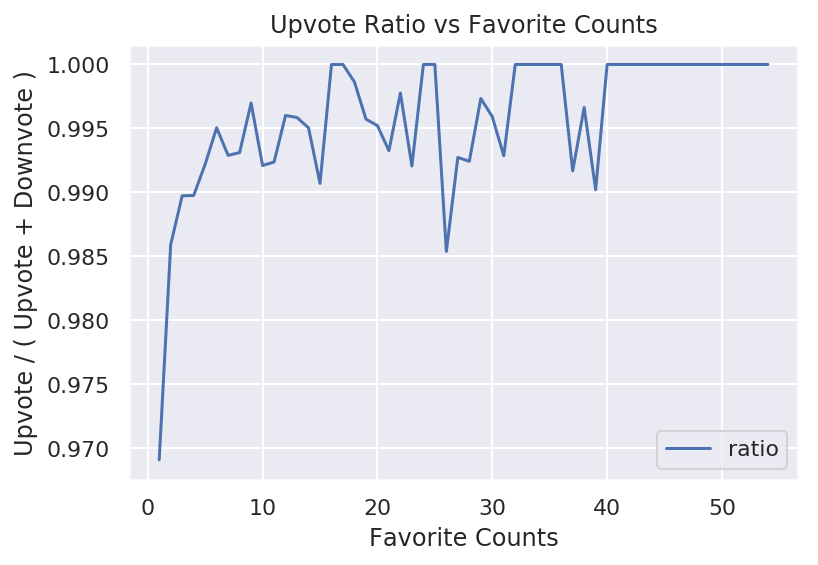

In [31]:
import pandas as pd
ratio = pd.DataFrame(res_2,columns=['key','ratio'])
ratio.plot(x='key',y='ratio')
plt.title('Upvote Ratio vs Favorite Counts')
plt.xlabel('Favorite Counts')
plt.ylabel('Upvote / ( Upvote + Downvote )')
plt.legend(loc = 'lower right')

From this exploratory analysis, we can see that the ratio of upvote does increase with the favorite counts, which makes sense.

## Answer percentage


Next, I will investigate the correlation between a user's reputation and the kind of posts they make. For the 99 users with the highest reputation, I will single out posts which are either questions or answers and look at the percentage of these posts that are answers: *(answers / (answers + questions))*. 

I will find out their **user ID** and this fraction.

I will also return this fraction where I average over all users to see the difference.

I will run this on the smaller data set.

In [32]:
# Switched to use the dataframe 
users = sc.textFile(localpath('spark-stats-data/allUsers/'))
# create user df
df_user = ((users.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(User.parse)
        .map(lambda x: (x.Id,x.reputation))
        .toDF(['Id','reputation'])))

# create question and answer table for each user
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))
df_post = ((posts.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(Post.parse)
        .map(lambda x: (x.owneruserid,x.posttypeid,1))
        .toDF(['ownerid','posttype','count'])))
question = (df_post.filter(F.col('posttype') == 1)
               .groupby('ownerid')
               .agg({'count':'sum'})
               .withColumnRenamed('sum(count)','count'))
answer =   (df_post.filter(F.col('posttype') == 2)
               .groupby('ownerid')
               .agg({'count':'sum'})
               .withColumnRenamed('sum(count)','count'))
# join the question and answer tables together and then join with the user table
joined_3 = (df_user.join(question, df_user.Id == question.ownerid,'left')
            .selectExpr('Id','reputation','count as question')
            .join(answer, F.col('Id') == answer.ownerid,'left')
            .selectExpr('Id','reputation','question','count as answer')
            .fillna(0)
            .withColumn('ratio', 
                 F.col('answer')/(F.col('answer')+F.col('question')))
            .orderBy(F.col('reputation').desc()))
# take the 99 users with highest reputations
res_3 = joined_3.select('Id','ratio').limit(99).collect()
# take the average over the whole user base
res_3_tot = joined_3.agg({'ratio':'mean'}).collect()

We can take a sample to see what the results look like (userid, answer_ratio):

In [33]:
res_3 = [(row[0],row[1]) for row in res_3]
res_3[:3]

[(919, 0.996694214876033),
 (805, 0.9959749552772809),
 (686, 0.9803049555273189)]

In [36]:
high_rep = sum(v[1] for v in res_3) / len(res_3)
print('The average answer ratio for high reputation users is : %0.5f' % (high_rep,))
print('The average answer ratio for the whole population is : %0.5f' % (res_3_tot[0][0]))

The average answer ratio for high reputation users is : 0.92776
The average answer ratio for the whole population is : 0.19994


The average answer ration for high reputation users (99 highest) is **0.92776** while that is **0.19994** for the whole user base. We can clearly see that users with high reputations tend to answer questions instead of asking ones.

## Post counts


If we use the total number of posts made on the site as a metric for tenure, we can look at the differences between "younger" and "older" users. You can imagine there might be many interesting features - for now just return the top 100 post counts among all users (of all types of posts) and the average reputation for every user who has that count.

In other words, aggregate the cases where multiple users have the same post count.


In [37]:
# make a post table to summarize the post counts for each user
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))
df_post = ((posts.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(Post.parse)
        .map(lambda x: (x.owneruserid,x.posttypeid,1))
        .toDF(['ownerid','posttype','count']))
        .groupby('ownerid')
        .agg({'count':'sum'})
        .withColumnRenamed('sum(count)','count'))
# make a user table containing the user reputation
users = sc.textFile(localpath('spark-stats-data/allUsers/'))
df_user = ((users.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(User.parse)
        .map(lambda x: (x.Id,x.reputation))
        .toDF(['Id','reputation'])))
# join the two tables together and aggregate over the post counts
joined_4 = (df_user.join(df_post, df_user.Id == df_post.ownerid,'inner')
            .selectExpr('Id','reputation','count')
            .groupby('count')
            .agg({'reputation':'mean'})
            .orderBy(F.col('count').desc())).take(100)

In [41]:
res_4 = [(row[0],row[1]) for row in joined_4]

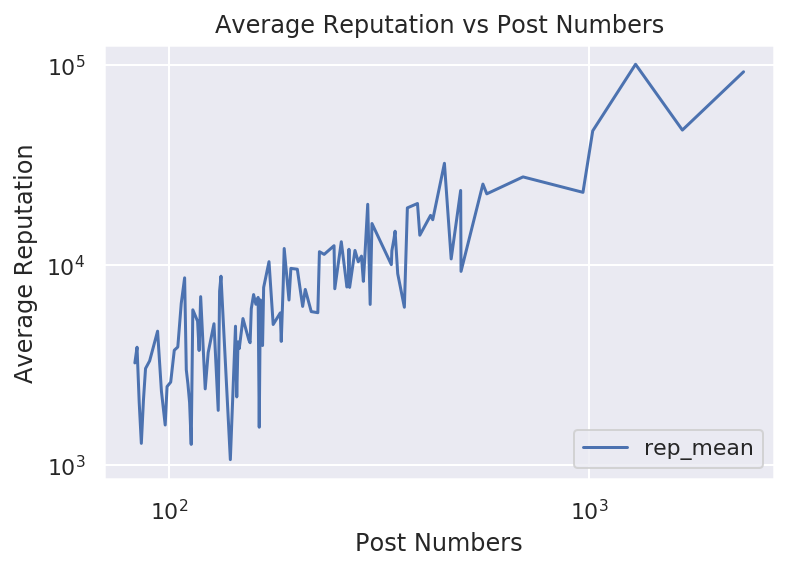

In [46]:
ratio = pd.DataFrame(res_4,columns=['post_count','rep_mean'])
ratio[ratio.rep_mean > 100].plot(x='post_count',y='rep_mean')
plt.title('Average Reputation vs Post Numbers')
plt.xlabel('Post Numbers')
plt.xscale('log')
plt.ylabel('Average Reputation')
plt.yscale('log')
plt.legend(loc = 'lower right')

**Conlusion**


The figure above suggests that post numbrs and reputation correlate positively. Users with higher reputation make more posts regardless of answers or questions.

## Quick answers


How long do you have to wait to get your question answered? Look at the set of ACCEPTED answers which are posted less than three hours after question creation. What is the average number of these "quick answers" as a function of the hour of day the question was asked? I will normalize by how many total accepted answers are garnered by questions posted in a given hour, just like we're counting how many quick accepted answers are garnered by questions posted in a given hour, eg. (quick accepted answers when question hour is 15 / total accepted answers when question hour is 15).

I will find out a list, whose *i*th element correspond to *i*th hour (e.g. 0 -> midnight, 1 -> 1:00, etc.)

### RDD and DataFrame approaches

In [52]:
# RDD method
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))

rdd_5 = (posts.map(lambda line: line.strip())
            .filter(lambda line: line.startswith('<row'))
            .filter(lambda line: '/>' in line)
            .map(Post.parse))
# self join the post table to figure out the accepted answer datetime 
# compare that with the question post creation datetime. if the difference
# is less than 3 hours, that is the numerator. The total counts of
# the accepted answers is the dominator. Aggregate by hous of the day
# datetime parsing is handled by datetime library in python
joined_5 = (rdd_5.map(lambda x: (x.acceptedanswerid,(x.creationdate.year,
                             x.creationdate.hour,x.creationdate)))
             .join(rdd_5.map(lambda x: (x.Id,x.creationdate)))
             .filter(lambda x: x[1][0][0]<2020)
             .map(lambda x: (x[1][0][1],(x[1][1]-x[1][0][2]).total_seconds(),1))
             .map(lambda x: (x[0],(bool_to_int(x[1]<3600*3),x[2])))
             .reduceByKey(lambda x,y: add_two(x,y))
             .map(lambda x: (x[0],x[1][0]/x[1][1]))
             .sortByKey()).collect()

res_5 = [(row[0],row[1]) for row in joined_5]

In [53]:
# Dataframe method, more human readable
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))
# create a post table
df = ((posts.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(Post.parse)
        .map(lambda x: (x.Id, x.posttypeid,
                        x.creationdate, x.acceptedanswerid))
        .toDF(['Id','posttype','creationdate','acceptedid'])))
# self join to find out the time difference. The other algorithm is the 
# same as the rdd method. The datetime parsing is handled with the generic 
# functions with the spark.
df_a = df.alias('df_a')
df_b = df.alias('df_b')
accepted_an = (df_a.join(df_b, 
                    F.col("df_a.acceptedid") == F.col("df_b.Id"),'inner')
               .selectExpr('df_a.Id as Id','df_a.creationdate as begin',
                           'df_b.creationdate as end')
               .withColumn('hour',
                F.col('begin').substr(12,2).cast(IntegerType()))
               .repartition('hour')
               .withColumn('year',
                F.col('begin').substr(1,4).cast(IntegerType()))
               .filter(F.col('year')<2020)
               .withColumn('begin_unix',F.unix_timestamp(F.col('begin')))
               .withColumn('end_unix',F.unix_timestamp(F.col('end')))
               .withColumn('delta', (F.col('end_unix')-F.col('begin_unix'))/3600)
               .select('Id','hour','delta')
               .withColumn('quick', F.when(F.col('delta')<=3,1)
                                     .otherwise(0))
               .groupBy('hour')
               .agg({'quick':'sum','delta':'count'})
               .withColumn('ratio',
                           F.col('sum(quick)')/F.col('count(delta)'))
               .orderBy('hour')
               .select('hour','ratio')).collect()

res_5_df = [(row[0],row[1]) for row in accepted_an]

The two approaches produce the identical results:

In [54]:
assert res_5 == res_5_df

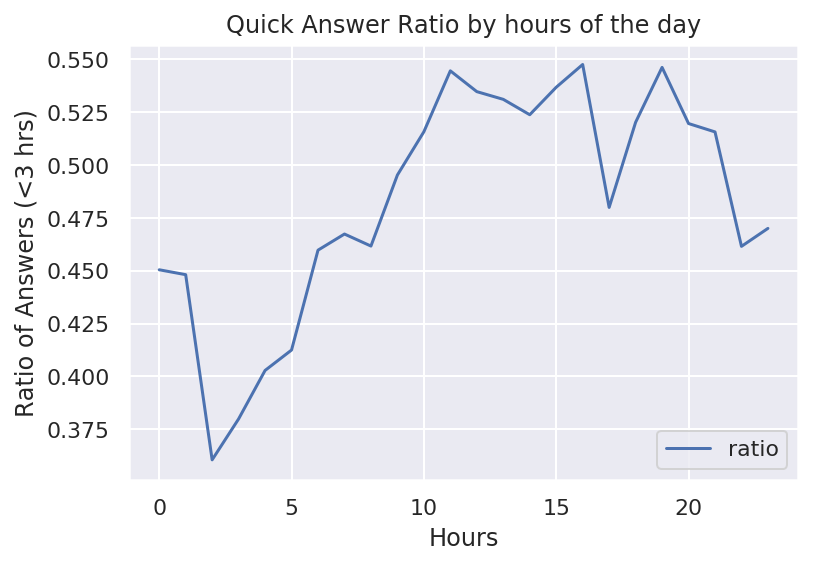

In [58]:
ratio = pd.DataFrame(res_5,columns=['hour','ratio'])
ratio.plot(x='hour',y='ratio')
plt.title('Quick Answer Ratio by hours of the day')
plt.xlabel('Hours')
plt.ylabel('Ratio of Answers (<3 hrs)')
plt.legend(loc = 'lower right')

**Conclusion**

This is an interesting finding. More than half of the questions are answered with 3 hours if the questions are posted between 10:00 and 16:00 and between 18:00 and 21:00. 17:00 might be a bad time to ask questions because people are most likely commuting.

### Local spark with hadoop file system

We will start to test out the scripts method, which will be the primary way to handle the spark jobs in the real world. I made two scripts in the local folder. One called `myutils.py` contains all the helper functions and class definitions. The other named `qn5_rdd_cloud.py` has the rdd methods we test above. It accepts two inputs, one for the location of the input, the other for the output. 

The following two blocks of the bash commands will be run in the notebook.

In [59]:
!rm -r out5
!spark-submit --master local[*] --py-files myutils.py qn5_rdd_cloud.py \
    hdfs:///user/stats/allPosts/ out5
!cat out5/* | sort -n -t , -k 1.2 -o out5/sorted_output

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/spark-2.2.0-bin-hadoop2.6/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/zookeeper/lib/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
18/12/02 23:31:45 INFO spark.SparkContext: Running Spark version 2.2.0
18/12/02 23:31:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
18/12/02 23:31:45 INFO spark.SparkContext: Submitted application: Quickanswer
18/12/02 23:31:45 INFO spark.SecurityManager: Changing view acls to: vagrant
18/12/02 23:31:45 INFO spark.SecurityManager: Changing modify acls to: vagrant
18/12/02 23:31:45 INFO spark.SecurityManager: Changing view acls groups to: 
18/12/02

18/12/02 23:31:47 INFO spark.SparkContext: Created broadcast 0 from textFile at NativeMethodAccessorImpl.java:0
18/12/02 23:31:47 INFO mapred.FileInputFormat: Total input paths to process : 11
18/12/02 23:31:47 INFO spark.SparkContext: Starting job: sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31
18/12/02 23:31:47 INFO scheduler.DAGScheduler: Registering RDD 6 (join at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:26)
18/12/02 23:31:47 INFO scheduler.DAGScheduler: Registering RDD 10 (reduceByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:30)
18/12/02 23:31:47 INFO scheduler.DAGScheduler: Got job 0 (sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31) with 22 output partitions
18/12/02 23:31:47 INFO scheduler.DAGScheduler: Final stage: ResultStage 2 (sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31)
18/12/02 23:31:47 INFO scheduler.DAGScheduler: Parents of final stage: List(ShuffleMapStage 1)
18/12/02 23:31:47 INFO scheduler.DAGScheduler: 

18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:48 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:

18/12/02 23:31:54 INFO compress.CodecPool: Got brand-new decompressor [.gz]
18/12/02 23:31:54 INFO python.PythonRunner: Times: total = 3412, boot = 18, init = 916, finish = 2478
18/12/02 23:31:54 INFO python.PythonRunner: Times: total = 3580, boot = 115, init = 662, finish = 2803
18/12/02 23:31:54 INFO executor.Executor: Finished task 2.0 in stage 0.0 (TID 2). 1587 bytes result sent to driver
18/12/02 23:31:54 INFO executor.Executor: Finished task 8.0 in stage 0.0 (TID 8). 1587 bytes result sent to driver
18/12/02 23:31:54 INFO scheduler.TaskSetManager: Finished task 2.0 in stage 0.0 (TID 2) in 5989 ms on localhost (executor driver) (10/22)
18/12/02 23:31:54 INFO scheduler.TaskSetManager: Finished task 8.0 in stage 0.0 (TID 8) in 5987 ms on localhost (executor driver) (11/22)
18/12/02 23:31:54 INFO executor.Executor: Finished task 15.0 in stage 0.0 (TID 15). 1587 bytes result sent to driver
18/12/02 23:31:54 INFO scheduler.TaskSetManager: Finished task 15.0 in stage 0.0 (TID 15) in 602

18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:57 INFO storage.ShuffleBlockFetcherItera

18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 68, boot = -4129, init = 4167, finish = 30
18/12/02 23:31:58 INFO executor.Executor: Finished task 17.0 in stage 1.0 (TID 39). 1716 bytes result sent to driver
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 45, boot = -847, init = 867, finish = 25
18/12/02 23:31:58 INFO scheduler.TaskSetManager: Finished task 17.0 in stage 1.0 (TID 39) in 106 ms on localhost (executor driver) (17/22)
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 81, boot = -3303, init = 3352, finish = 32
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 58, boot = -755, init = 770, finish = 43
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 83, boot = -3345, init = 3371, finish = 57
18/12/02 23:31:58 INFO executor.Executor: Finished task 18.0 in stage 1.0 (TID 40). 1802 bytes result sent to driver
18/12/02 23:31:58 INFO executor.Executor: Finished task 16.0 in stage 1.0 (TID 38). 1759 bytes result sent to driver
18/1

18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Started 0 remote fetches in 1 ms
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 10, boot = -411, init = 421, finish = 0
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 15, boot = -882, init = 896, finish = 1
18/12/02 23:31:58 INFO executor.Executor: Finished task 14.0 in stage 2.0 (TID 58). 1525 bytes result sent to driver
18/12/02 23:31:58 INFO python.PythonRunner: Times: total = 45, boot = -640, init = 684, finish = 1
18/12/02 23:31:58 INFO executor.Executor: Finished task 8.0 in stage 2.0 (TID 52). 1525 bytes result sent to driver
18/12/02 23:31:58 INFO scheduler.TaskSetManager: Starting task 16.0 in stage 2.0 (TID 60, localhost, executor driver, partition 16, ANY, 4621 bytes)
18/12/02 23:31:58 INFO executor.Executor: Running task 16.0 in stage 2.0 (TID 60)
18/12/02 23:31:58 INFO scheduler.TaskSetM

18/12/02 23:31:58 INFO spark.SparkContext: Starting job: sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31
18/12/02 23:31:58 INFO spark.MapOutputTrackerMaster: Size of output statuses for shuffle 1 is 397 bytes
18/12/02 23:31:58 INFO spark.MapOutputTrackerMaster: Size of output statuses for shuffle 0 is 168 bytes
18/12/02 23:31:58 INFO scheduler.DAGScheduler: Got job 1 (sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31) with 22 output partitions
18/12/02 23:31:58 INFO scheduler.DAGScheduler: Final stage: ResultStage 5 (sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31)
18/12/02 23:31:58 INFO scheduler.DAGScheduler: Parents of final stage: List(ShuffleMapStage 4)
18/12/02 23:31:58 INFO scheduler.DAGScheduler: Missing parents: List()
18/12/02 23:31:58 INFO scheduler.DAGScheduler: Submitting ResultStage 5 (PythonRDD[14] at sortByKey at /home/vagrant/showcases/spark/qn5_rdd_cloud.py:31), which has no missing parents
18/12/02 23:31:58 INFO memory.Memor

18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Started 0 remote fetches in 0 ms
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:58 INFO scheduler.TaskSetManager: Starting task 18.0 in stage 5.0 (TID 84, localhost, executor driver, partition 18, ANY, 4621 bytes)
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Started 0 remote fetches in 0 ms
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Started 0 remote fetches in 1 ms
18/12/02 23:31:58 INFO scheduler.TaskSetManager: Finished task 0.0 in stage 5.0 (TID 66) in 55 ms on localhost (executor driver) (1/22)
18/12/02 23:31:58 INFO storage.ShuffleBlockFetcherIterator: Getting 22 non-empty blocks out of 22 blocks
18/12/02 23:31:5

Traceback (most recent call last):
  File "/home/vagrant/showcases/spark/qn5_rdd_cloud.py", line 37, in <module>
    main(*sys.argv[1:])
  File "/home/vagrant/showcases/spark/qn5_rdd_cloud.py", line 33, in main
    .saveAsTextFile(output_fn))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/rdd.py", line 1553, in saveAsTextFile
  File "/opt/spark/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1133, in __call__
  File "/opt/spark/python/lib/py4j-0.10.4-src.zip/py4j/protocol.py", line 319, in get_return_value
py4j.protocol.Py4JJavaError: An error occurred while calling o108.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory hdfs://localhost/user/vagrant/out5 already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:132)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1119)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDa

In [61]:
!mkdir out5
!hadoop fs -copyToLocal /user/vagrant/out5/* out5/
!cat out5/* | sort -n -t , -k 1.2 -o out5/sorted_output

In [70]:
with open('out5/sorted_output','r') as f:
    res_5_hdfs = f.read()
res_5_hdfs = [(int(line[1:3].replace(',','')),float(line.replace(')','').split(',')[1].strip())) 
       for line in res_5_hdfs.split('\n') if line]

I will make sure that we get the same results as above:

In [72]:
assert res_5 == res_5_hdfs

## Quick answers&mdash;full


Now comes to the real deal. We will run our tested scripts on the full data set. Be hold, this will take quite a while to finish. I will use the GCP to accomplish this task. The following are the command lines that need to be run in **terminal** . The initialization scripts, `myutils.py`, `qn5_rdd_cloud.py`, and  full data set are all stored in the GCP bucket.

### GCP approach

#### GCP making cluster

In [ ]:
# more powerful
!gcloud dataproc clusters create cluster-1 --initialization-actions \
    gs://camalot/cluster_init.sh --region us-west2 --zone us-west2-a \
    --master-machine-type n1-standard-2 --master-boot-disk-size 500GB \
    --num-workers 3 \
    --worker-machine-type n1-standard-4 --worker-boot-disk-size 500GB \
    --num-worker-local-ssds 1 --project tdi2018-217422

In [ ]:
# delete the output folder if it already exists
!gsutil rm -r gs://camalot/output

#### Job submittion

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster cluster-1 --region us-west2 \
    --py-files gs://camalot/datacourse/spark.new/miniprojects/myutils.py \
    gs://camalot/datacourse/spark.new/miniprojects/qn5_rdd_cloud.py \
    -- gs://camalot/datacourse/spark.new/miniprojects/spark-stack-data/allPosts/ \
            gs://camalot/output/

#### results handling

In [ ]:
!mkdir out6
!gsutil -m cp gs://camalot/output/* out6
!cat out6/* | sort -n -t , -k 1.2 -o out6/sorted_output

In [74]:
with open('out6/sorted_output','r') as f:
    res_6_gcp = f.read()
res_6_gcp = [(int(line[1:3].replace(',','')),float(line.replace(')','').split(',')[1].strip())) 
       for line in res_6_gcp.split('\n') if line]

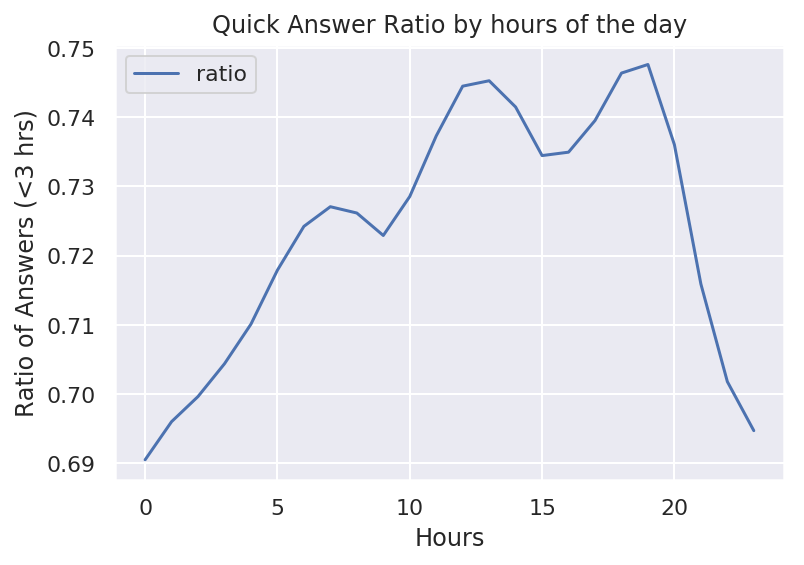

In [78]:
ratio = pd.DataFrame(res_6_gcp,columns=['hour','ratio'])
ratio.plot(x='hour',y='ratio')
plt.title('Quick Answer Ratio by hours of the day')
plt.xlabel('Hours')
plt.ylabel('Ratio of Answers (<3 hrs)')
plt.legend(loc = 'upper left')

The full data analysis shown in the above figure reveals the same trend as the last question. Questions asked between 10:00 and 20:00 have higher ratio of getting answered within 3 hours. There are three humps at 7:00-8:00, 12:00-13:00, and 18:00-19:00, which may correspond to morning commute, lunch break, and evening commute. 

In [ ]:
# shut down cluster at the end
!gcloud dataproc clusters delete cluster-1 --region us-west2

## Identify veterans


It can be interesting to think about what factors influence a user to remain active on the site over a long period of time. In order not to bias the results towards older users, we'll define a time window between 100 and 150 days after account creation. If the user has made a post in this time, we'll consider them active and well on their way to being veterans of the site; if not, they are inactive and were likely brief users.

Let's see if there are differences between the first ever question posts of "veterans" vs. "brief users". For each group separately, we will average the score, views, number of answers, and number of favorites of the users' **first question**.

In [79]:
# create the user tables with the user creation date info
users = sc.textFile(localpath('spark-stats-data/allUsers/'))
df_user = ((users.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(User.parse)
        .map(lambda x: (x.Id,x.creationdate))
        .toDF(['userid','usercreationdate'])))
# create the post table with the post creation date and other metrics
posts = sc.textFile(localpath('spark-stats-data/allPosts/'))
df_post = ((posts.map(lambda line: line.strip())
        .filter(lambda line: line.startswith('<row'))
        .filter(lambda line: '/>' in line)
        .map(Post.parse)
        .map(lambda x: (x.owneruserid,x.posttypeid,x.creationdate,x.score,
                        x.viewcount,x.answercount,x.favoritecount))
        .toDF(['ownerid','posttypeid','postcreationdate','score',
               'views','answers','favorite'])))
# join the two table and calculate the time difference between
# post creation date and the user creation date
joined_7 = (df_post.join(df_user, df_post.ownerid == df_user.userid,'inner')
               .withColumn('delta(days)',
                (F.unix_timestamp('postcreationdate')-
                 F.unix_timestamp('usercreationdate'))/3600/24)
               .withColumn('veterans', 
                 F.when(F.col('delta(days)').between(100,150), 1)
                  .otherwise(0)))
# select the veterans and cache the results to make the 
# following analysis quicker
veterans = (joined_7.filter(F.col('veterans') == 1)[['userid']]
                .distinct()).cache()

w = Window.partitionBy('ownerid').orderBy('postdate')
# create two tables one for veterans, the other for brief users.
# the very first question is selected by using the window function
# veterans are created by 'leftsemi' join
# brief users are created by 'leftanti' join
vet = (joined_7.selectExpr('ownerid','posttypeid','postcreationdate as postdate',
                       'score','views','answers','favorite')
           .join(veterans, joined_7.ownerid == veterans.userid,'leftsemi')
           .filter(F.col('posttypeid') == 1)
           .withColumn('rn',F.row_number().over(w))
           .filter(F.col('rn') == 1)
           .agg({'score':'mean',
                 'views':'mean',
                 'answers':'mean',
                 'favorite':'mean'})
           .select(F.col('avg(score)').alias('vet_score'),
                   F.col('avg(views)').alias('vet_views'),
                   F.col('avg(answers)').alias('vet_answers'),
                   F.col('avg(favorite)').alias('vet_favorites')))

stats_vet = vet.collect()

brief = (joined_7.selectExpr('ownerid','posttypeid','postcreationdate as postdate',
                       'score','views','answers','favorite')
           .join(veterans, joined_7.ownerid == veterans.userid,'leftanti')
           .filter(F.col('posttypeid') == 1)
           .withColumn('rn',F.row_number().over(w))
           .filter(F.col('rn') == 1)
           .agg({'score':'mean',
                 'views':'mean',
                 'answers':'mean',
                 'favorite':'mean'})
           .select(F.col('avg(score)').alias('brief_score'),
                   F.col('avg(views)').alias('brief_views'),
                   F.col('avg(answers)').alias('brief_answers'),
                   F.col('avg(favorite)').alias('brief_favorites')))

stats_brief = brief.collect()

In [80]:
res_7 = []
res_7.append(stats_vet[0])
res_7.append(stats_brief[0])
res_7 = [row.asDict() for row in res_7]
for k,v in res_7[1].items():
    res_7[0].update({k:v})
res_7 = res_7[0]

In [86]:
print('The metrics for the very first questions asked are :')
for k,v in res_7.items():
    print('The %s is %0.5f' % (k,v))

The metrics for the very first questions asked are :
The vet_score is 3.54345
The vet_views is 926.39824
The vet_answers is 1.29813
The vet_favorites is 1.30088
The brief_score is 2.10081
The brief_views is 553.51920
The brief_answers is 0.97072
The brief_favorites is 0.57588


The very first questions asked by the veterans have much better metrics than the brief users (veterans vs brief users): 
- score:   **3.54345**        vs   **2.10081**
- views:   **926.39824**      vs   **553.51920**
- answers:   **1.29813**      vs   **0.97072**
- favorites: **1.30088**      vs   **0.57588**

This might suggest that users tend to stay longer if they are encouraged and praised at their initial user experience on the stack overflow website. 

## Identify veterans&mdash;full


Same as above, but now on the full data set. Let's see what the results will tell us.

Again, the following blocks are going to be run in the **terminal**

In [ ]:
# more powerful
!gcloud dataproc clusters create cluster-1 --initialization-actions \
    gs://camalot/cluster_init.sh --region us-west2 --zone us-west2-a \
    --master-machine-type n1-standard-2 --master-boot-disk-size 500GB \
    --num-workers 3 \
    --worker-machine-type n1-standard-4 --worker-boot-disk-size 500GB \
    --num-worker-local-ssds 1 --project tdi2018-217422

In [ ]:
# delete the output folder if it already exists
!gsutil rm -r gs://camalot/output

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster cluster-1 --region us-west2 \
    --py-files gs://camalot/datacourse/spark.new/miniprojects/myutils.py \
    gs://camalot/datacourse/spark.new/miniprojects/qn7_df_cloud.py \
    -- gs://camalot/datacourse/spark.new/miniprojects/spark-stack-data/allUsers/ \
       gs://camalot/datacourse/spark.new/miniprojects/spark-stack-data/allPosts/ \
       gs://camalot/output/vet \
       gs://camalot/output/brief

In [ ]:
!mkdir out8
!gsutil -m cp -r gs://camalot/output/* out8/

In [ ]:
# shut down cluster at the end
!gcloud dataproc clusters delete cluster-1 --region us-west2

In [106]:
with open('out8/vet/part-00000','r') as f:
    stats_vet = f.read()
with open('out8/brief/part-00000','r') as f:
    stats_brief = f.read()
stats_vet = stats_vet.strip()[4:-1].split(',')
stats_vet = [(str(row.split('=')[0].strip()),float(row.split('=')[1])) 
             for row in stats_vet]
stats_brief = stats_brief.strip()[4:-1].split(',')
stats_brief = [(str(row.split('=')[0].strip()),float(row.split('=')[1])) 
               for row in stats_brief]
res_8 = dict(stats_vet+stats_brief)

In [107]:
print('The metrics for the very first questions asked are :')
for k,v in res_8.items():
    print('The %s is %0.5f' % (k,v))

The metrics for the very first questions asked are :
The vet_score is 2.25984
The vet_views is 1844.03449
The vet_answers is 1.84262
The vet_favorites is 0.86732
The brief_score is 1.13075
The brief_views is 1096.15192
The brief_answers is 1.50386
The brief_favorites is 0.38618


**Conclusions**

The very first questions asked by the veterans vs the brief users in the full data set (veterans vs brief users): 
- score:   **2.25984**        vs   **1.13075**
- views:   **1844.03449**      vs   **1096.15192**
- answers:   **1.84262**      vs   **1.50386**
- favorites: **0.86732**      vs   **0.38618**

The metrics are slightly different than the ones we get from analyzing the smaller data set. But, our conclusion still holds. Veterans have much bettern first question metrics than the ones from the brief users. 

## Word2vec


Word2Vec is an alternative approach for vectorizing text data. The vectorized representations of words in the vocabulary tend to be useful for predicting other words in the document, hence the famous example "vector('king') - vector('man') + vector('woman') ~= vector('queen')".

Let's see how good a Word2Vec model we can train using the tags of each Stack Exchange post as documents (this uses the full data set). I will use the implementation of Word2Vec from Spark ML (this will require using DataFrames) to return a list of the top 25 closest synonyms to "ggplot2" and their similarity score. I will make a wordclound figure based on the calculated frequencies to visualize the words.

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster cluster-1 --region us-west2\
    --py-files gs://camalot/datacourse/spark.new/miniprojects/myutils.py \
    gs://camalot/datacourse/spark.new/miniprojects/qn9_df_cloud.py \
    -- gs://camalot/datacourse/spark.new/miniprojects/spark-stack-data/allPosts/ \
            gs://camalot/output/

In [ ]:
!mkdir out9
!gsutil -m cp -r gs://camalot/output/* out9
!cat out9/* | sort -n -t , -k 1.2 -o out9/sorted_output

In [102]:
# results handling
with open('out9/sorted_output','r') as f:
    res_9 = f.read()
res_9 = [(str(line.replace('(','').replace("'",'').split(',')[0]),
        float(line.replace(')','').split(',')[1].strip())) 
       for line in res_9.split('\n') if line]
res_9 = sorted(res_9,key=lambda x: -x[1])
res_9[:5]

[('lattice', 0.8987874984741211),
 ('r-grid', 0.8651634454727173),
 ('plotrix', 0.8403352499008179),
 ('boxplot', 0.8390781283378601),
 ('levelplot', 0.8236628770828247)]

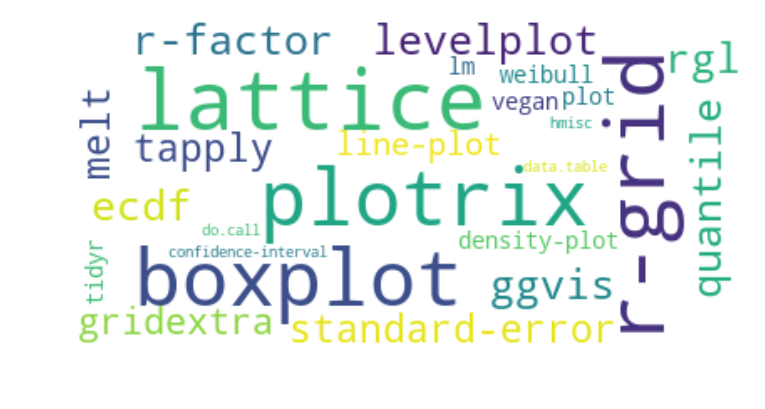

In [105]:
from wordcloud import WordCloud
# data visulization with wordcloud. the bigger the font, the similar of the word
words = dict(res_9)
wordcloud = (WordCloud(max_font_size=50, max_words=100, background_color="white")
             .generate_from_frequencies(words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Conclusions**

From this nice wordcloud figure, we can see that "ggplot" has been associated more often with words like "lattice", "boxplot", etc. The association makes sense because we know that "ggplot" is a common plotting tools used in R. 

## Classification


We'd like to see if we can predict the tags of a question from its body text. Technically this is a multi-label classification problem, but to simplify things we'll use a one-vs-all approach where we choose the top k most common tags and train k binary classifiers where the labels indicate the presence or absence of that tag.

We will use a logistic regression model as the classifier.

Since we can't reliably save and load models, return a list of 100 tuples ("string", [number, number, number,...]) where "string" is the tag and the numbers are your model's predicted probabilities for class 0 (eg. 0.2 means a prediction that the tag is present) across the test set.

The zip files are downloaded already at the beginning in the `spark-stats-data` folder locally. We will extract the xml files out:

In [ ]:
# prepare for the unzipping
!mkdir ./spark-stats-data/train
!mkdir ./spark-stats-data/test

In [ ]:
# extract the files out of zipped files
import zipfile
z1 = zipfile.ZipFile('./spark-stats-data/posts_train.zip')
z1.extractall('./spark-stats-data/train')
z2 = zipfile.ZipFile('./spark-stats-data/posts_test.zip')
z2.extractall('./spark-stats-data/test')

In [118]:
# making the train table
# filter out the entries with no tags
# split the tags and cache the train table
train = sc.textFile(localpath('spark-stats-data/train/'))
df_train = (train.map(lambda line: line.strip())
            .filter(lambda line: line.startswith('<row'))
            .filter(lambda line: '/>' in line)
            .map(Post.parse)
            .map(lambda x: (x.paragraph,x.tags))
            .filter(lambda x: x[1]!="")
            .toDF(['body','tags'])
            .withColumn('tags',F.regexp_replace(F.col('tags'),'<',''))
            .withColumn('tags',F.lower(F.col('tags')))
            .withColumn('tags',F.split(F.col('tags'),'>'))).cache()

# making the test table, same as above
test = sc.textFile(localpath('spark-stats-data/test/'))
df_test = (test.map(lambda line: line.strip())
            .filter(lambda line: line.startswith('<row'))
            .filter(lambda line: '/>' in line)
            .map(Post.parse)
            .map(lambda x: (x.paragraph,x.tags))
            .filter(lambda x: x[1]!="")
            .toDF(['body','tags'])
            .withColumn('tags',F.regexp_replace(F.col('tags'),'<',''))
            .withColumn('tags',F.lower(F.col('tags')))
            .withColumn('tags',F.split(F.col('tags'),'>')))

def parse_tags(tags):
    '''parse the tag string into list of words'''
    if len(tags) < 1:
        return ''
    else:
        tags = tags.replace('<','')
        tags = tags.lower()
        return tags.split('>')
    
# count the top100 words in tags
top100 = (train.map(lambda line: line.strip())
            .filter(lambda line: line.startswith('<row'))
            .filter(lambda line: '/>' in line)
            .map(Post.parse)
            .flatMap(lambda x: parse_tags(x.tags))
            .filter(lambda word: word != "")
            .map(lambda word: (word,1))
            .reduceByKey(lambda x,y: x+y)
            .sortBy(lambda x: -x[1])
            .map(lambda x: x[0])).take(100)

In [119]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# build the pipeline and crossvalidation model, one-vs-all model
tokenizer = Tokenizer(inputCol="body", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
logreg = LogisticRegression(maxIter=10)

pipeline = Pipeline(stages=[tokenizer, hashingTF, logreg])

paramGrid = (ParamGridBuilder() 
                .addGrid(hashingTF.numFeatures, [100, 1000]) 
                .addGrid(logreg.regParam, [0.1, 0.01]) 
                .build())

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [120]:
from tqdm import tqdm_notebook
# building the one-vs-all model
res_10 = []
for tag in tqdm_notebook(top100):
    df_train = (df_train.withColumn('label',
                        F.when(F.array_contains(F.col('tags'),tag),1)
                                            .otherwise(0)))
    cvModel = crossval.fit(df_train)
    prediction = cvModel.transform(df_test)
    selected = prediction.select('probability')
    probability = [prob[0][1] for prob in selected.collect()]
    res_10.append((tag,probability))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [124]:
# save the results
import dill
dill.dump(res_10, open('res_10.dill','wb'))

In [155]:
import numpy as np
# get the term_doc and doc_term matrixes
term_doc = np.array([x[1] for x in res_10])
doc_term = term_doc.T
# get the labels from the highest probability
top100_arr = np.array(top100)
labels = [top100_arr[np.argmax(doc)] for doc in doc_term]

In [171]:
# compare the predictions and the actual labels in the test set
actual =[]
for row in df_test[['tags']].take(10):
    a = 'r' if 'r' in row[0] else ' '
    actual.append(a)

print('The predicted most likely labels for the first 10 docs are :'+'\n'+
      ' | '.join(labels[:10]))
print('The actual docs containing the predicted labels are :'+'\n'+
      ' | '.join(actual[:10]))

The predicted most likely labels for the first 10 docs are :
r | r | r | r | r | r | r | r | r | r
The actual docs containing the predicted labels are :
r |   |   |   | r |   |   |   | r |  


The prediction only achieves **~30% Accuracy** for the first 10 test samples. I haven't test the predition thoroughly to prove the results though. At least, we have demonstrated the ability to run the machine learning processes in the spark frame work.